In [1]:
!pip install torch-geometric
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 15.6 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=c26f9ca35e9cedd93fc55a39956eec86f283408ea9637c721d0b58d3ec49fe1f
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 14.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 11.1 MB/s 


In [3]:
import torch
import numpy as np

import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt
from utilities import *
from nn_conv import NNConv, NNConv_old

from timeit import default_timer
import scipy.io

from SCA1D import *

In [122]:
class SCA_data():
    def generator():
        data=[]
        cluster_num = np.arange(6, 129, 4)
        strain_list = [0.1]
        for i in cluster_num:
            for j in strain_list:
                sca = SCA1D(i,j)
                result = sca.SCA_data()
                data.append(result)
        return data
    def generator1():
        data=[]
        cluster_num = [300]
        strain_list = [0.1, 0.2, 0.3]
        for i in cluster_num:
            for j in strain_list:
                sca = SCA1D(i,j)
                result = sca.SCA_data()
                data.append(result)
        return data
    def normalizer(data):
        for j in range(len(data)):
            data[j][1,:] = data[j][1,:]/max(data[j][1,:])
            data[j][2,:] = (data[j][2,:] - min(data[j][2,:]))/(max(data[j][2,:])- min(data[j][2,:]))
        return data
class SCAMeshGenerator():
    def __init__(self, grid, input, output):
        self.grid = grid.reshape(-1,1)
        self.input = input
        self.output = output
        self.d  = 1
    
    def get_grid(self):
        return torch.tensor(self.grid, dtype=torch.float)

    def get_input(self):
        return torch.tensor(self.input, dtype=torch.float)

    def get_output(self):
        return torch.tensor(self.output, dtype=torch.float)

    def ball_connectivity(self, r):
        pwd = sklearn.metrics.pairwise_distances(self.grid)
        self.edge_index = np.vstack(np.where(pwd <= r))
        self.n_edges = self.edge_index.shape[1]

        return torch.tensor(self.edge_index, dtype=torch.long)

    def gaussian_connectivity(self, sigma):
        pwd = sklearn.metrics.pairwise_distances(self.grid)
        rbf = np.exp(-pwd**2/sigma**2)
        sample = np.random.binomial(1,rbf)
        self.edge_index = np.vstack(np.where(sample))
        self.n_edges = self.edge_index.shape[1]
        return torch.tensor(self.edge_index, dtype=torch.long)


    def attributes(self, f=None, theta=None):
        if f is None:
            if theta is None:
                edge_attr = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
            else:
                edge_attr = np.zeros((self.n_edges, 2*self.d+2))
                edge_attr[:,0:2*self.d] = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
                edge_attr[:, 2 * self.d] = theta[self.edge_index[0]]
                edge_attr[:, 2 * self.d +1] = theta[self.edge_index[1]]
        else:
            xy = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
            if theta is None:
                edge_attr = f(xy[:,0:self.d], xy[:,self.d:])
            else:
                edge_attr = f(xy[:,0:self.d], xy[:,self.d:], theta[self.edge_index[0]], theta[self.edge_index[1]])

        return torch.tensor(edge_attr, dtype=torch.float)

In [58]:
data = SCA_data.generator()

data = SCA_data.normalizer(data)

In [6]:
class KernelNN(torch.nn.Module):
    def __init__(self, width, ker_width, depth, ker_in, in_width=1, out_width=1):
        super(KernelNN, self).__init__()
        self.depth = depth

        self.fc1 = torch.nn.Linear(in_width, width)

        kernel = DenseNet([ker_in, ker_width//2, ker_width, width**2], torch.nn.ReLU)
        self.conv1 = NNConv_old(width, width, kernel, aggr='mean')

        self.fc2 = torch.nn.Linear(width, ker_width)
        self.fc3 = torch.nn.Linear(ker_width, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.fc1(x)
        for k in range(self.depth):
            x = self.conv1(x, edge_index, edge_attr)
            if k != self.depth-1:
                x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [59]:
len(data)

30

In [61]:
ntrain = 25
ntest = 5



t1 = default_timer()
batch_size  = 1 # factor of ntrain * k
batch_size2 = 1 # factor of test_split

radius_train = 3
radius_test = 3
# rbf_sigma = 0.2



In [62]:
width = 50
ker_width = 500
depth = 5
edge_features = 4
node_features = 2

epochs = 101
learning_rate = 0.0001
scheduler_step = 10
scheduler_gamma = 0.85

In [63]:
data_train=[]
index = []
for i in range(ntrain):
    j = np.random.randint(1,len(data))
    grid = data[j][0,:]
    input = data[j][1,:]
    output = data[j][2,:]
    index.append(j)
    meshgenerator = SCAMeshGenerator(grid, input, output)
    grid = meshgenerator.get_grid()
    input = meshgenerator.get_input()
    output = meshgenerator.get_output()

    edge_index = meshgenerator.ball_connectivity(2)
    print(grid.size())
    print(edge_index.size())

    edge_attr = meshgenerator.attributes(theta = input)
    print(edge_attr.size())
    # data_train.append(Data(x=init_point.clone().view(-1,1), y=train_y[j,:], edge_index=edge_index, edge_attr=edge_attr))
    data_train.append(Data(x=torch.cat([grid.reshape(-1, 1), input.reshape(-1, 1)], dim=1),y=output, edge_index=edge_index, edge_attr=edge_attr))

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)

torch.Size([54, 1])
torch.Size([2, 1024])
torch.Size([1024, 4])
torch.Size([46, 1])
torch.Size([2, 784])
torch.Size([784, 4])
torch.Size([54, 1])
torch.Size([2, 1024])
torch.Size([1024, 4])
torch.Size([34, 1])
torch.Size([2, 400])
torch.Size([400, 4])
torch.Size([122, 1])
torch.Size([2, 5378])
torch.Size([5378, 4])
torch.Size([18, 1])
torch.Size([2, 114])
torch.Size([114, 4])
torch.Size([122, 1])
torch.Size([2, 5378])
torch.Size([5378, 4])
torch.Size([38, 1])
torch.Size([2, 514])
torch.Size([514, 4])
torch.Size([62, 1])
torch.Size([2, 1394])
torch.Size([1394, 4])
torch.Size([122, 1])
torch.Size([2, 5378])
torch.Size([5378, 4])
torch.Size([90, 1])
torch.Size([2, 2959])
torch.Size([2959, 4])
torch.Size([118, 1])
torch.Size([2, 4994])
torch.Size([4994, 4])
torch.Size([18, 1])
torch.Size([2, 114])
torch.Size([114, 4])
torch.Size([54, 1])
torch.Size([2, 1024])
torch.Size([1024, 4])
torch.Size([34, 1])
torch.Size([2, 400])
torch.Size([400, 4])
torch.Size([114, 1])
torch.Size([2, 4624])
torch

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [64]:
data_test = []
index_test = []
for j in range(len(data)):
    if j not in index:
        grid = data[j][0,:]
        input = data[j][1,:]
        output = data[j][2,:]
        index_test.append(j)
        meshgenerator = SCAMeshGenerator(grid, input, output)
        grid = meshgenerator.get_grid()
        input = meshgenerator.get_input()
        output = meshgenerator.get_output()

        edge_index = meshgenerator.ball_connectivity(2)
        print(edge_index.size())

        edge_attr = meshgenerator.attributes(theta = input)
        print(edge_attr.size())
        # data_train.append(Data(x=init_point.clone().view(-1,1), y=train_y[j,:], edge_index=edge_index, edge_attr=edge_attr))
        data_test.append(Data(x=torch.cat([grid.reshape(-1, 1), input.reshape(-1, 1)], dim=1), y=output, edge_index=edge_index, edge_attr=edge_attr))

test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

torch.Size([2, 44])
torch.Size([44, 4])
torch.Size([2, 64])
torch.Size([64, 4])
torch.Size([2, 178])
torch.Size([178, 4])
torch.Size([2, 256])
torch.Size([256, 4])
torch.Size([2, 342])
torch.Size([342, 4])
torch.Size([2, 923])
torch.Size([923, 4])
torch.Size([2, 1202])
torch.Size([1202, 4])
torch.Size([2, 2178])
torch.Size([2178, 4])
torch.Size([2, 2434])
torch.Size([2434, 4])
torch.Size([2, 2704])
torch.Size([2704, 4])
torch.Size([2, 3136])
torch.Size([3136, 4])
torch.Size([2, 3442])
torch.Size([3442, 4])
torch.Size([2, 3762])
torch.Size([3762, 4])
torch.Size([2, 4096])
torch.Size([4096, 4])
torch.Size([2, 4396])
torch.Size([4396, 4])


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [65]:
##################################################################################################

### training

##################################################################################################
t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

model = KernelNN(width,ker_width,depth,edge_features,node_features).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)

preprocessing finished, time used: 9.2576778990001


In [66]:
ttrain = np.zeros((epochs, ))
ttest = np.zeros((epochs,))
for ep in range(epochs):
    #u_normalizer.cuda()
    model.train()
    t1 = default_timer()
    train_mse = 0.0
    train_l2 = 0.0
    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch)
        mse = F.mse_loss(out.view(-1, 1), batch.y.view(-1,1))
        # mse.backward()
        loss = torch.norm(out.view(-1) - batch.y.view(-1),1)
        loss.backward()

        l2 = myloss(out.view(batch_size, -1), batch.y.view(batch_size, -1))
        # l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    ttrain[ep] = train_l2 /ntrain
    scheduler.step()
    t2 = default_timer()


    print(ep, t2-t1, train_mse/len(train_loader), train_l2 / ntrain)

    if ep % 1 == 0:
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():

              for batch in test_loader:
                  batch = batch.to(device)
                  out = model(batch).view(batch_size, -1).detach().cpu()
                  pred = batch.y.view(batch_size, -1).cpu()
                  test_l2 += myloss(out, pred).item()


              

        t3 = default_timer()
        ttest[ep] = test_l2 /ntest
        print(ep, t3-t2, test_l2/ntest)


0 0.8499398180001663 3876.2857744026182 82.03244297027588
0 0.1548848329998691 64.21813507080078
1 0.7806041419999019 9.297049771547318 4.8609567904472355
1 0.1594249290001244 2.2798218727111816
2 0.7754643220000617 0.0832662345515564 0.5562217971682548
2 0.15980779299979986 2.992772698402405
3 0.7740890239997498 0.06198246341431513 0.4945054551959038
3 0.1592909480000344 2.031213480234146
4 0.7841107730000658 0.04978452289476991 0.417910518348217
4 0.15791115999991234 1.1816347301006318
5 0.7810388870002498 0.034956425242125985 0.3534917947649956
5 0.15370452399974965 0.1900354541838169
6 0.781684456000221 0.09796753297327086 0.56796781539917
6 0.15661446400008572 1.141781610250473
7 0.7863128529997994 0.03935843275859952 0.35209464102983473
7 0.15605083499985994 0.5965583562850952
8 0.7826091259998975 0.019107034280896187 0.2704702436923981
8 0.16080737800029965 0.6684801980853081
9 0.7889709690002746 0.01566108356579207 0.23807051807641982
9 0.15685871300001963 0.7195175617933274
10

In [67]:
test_l2

0.6910911947488785

Text(0.5, 1.0, 'Training loss of GKN')

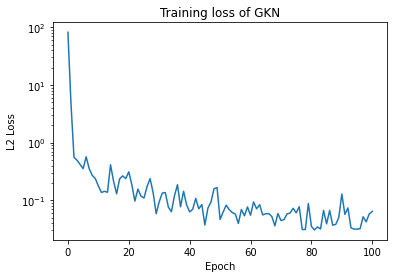

In [88]:
plt.plot(np.array((ttrain)))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('L2 Loss')

plt.title('Training loss of GKN')

Text(0.5, 1.0, 'Testing loss of GKN')

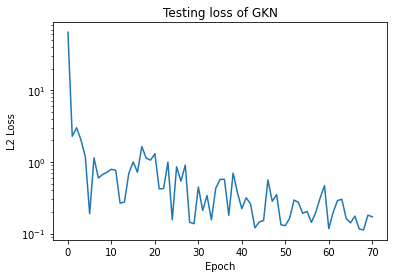

In [87]:
plt.plot(np.array((ttest)))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.title('Testing loss of GKN')

In [123]:
result = SCA_data.generator1()
result = SCA_data.normalizer(result)

In [124]:
data_vali=[]
j = 0
grid = result[j][0,:]
input = result[j][1,:]
output = result[j][2,:]
meshgenerator = SCAMeshGenerator(grid, input, output)
grid = meshgenerator.get_grid()
input = meshgenerator.get_input()
output = meshgenerator.get_output()

edge_index = meshgenerator.ball_connectivity(2)
print(grid.size())
print(edge_index.size())

edge_attr = meshgenerator.attributes(theta = input)
print(edge_attr.size())
# data_train.append(Data(x=init_point.clone().view(-1,1), y=train_y[j,:], edge_index=edge_index, edge_attr=edge_attr))
data_vali.append(Data(x=torch.cat([grid.reshape(-1, 1), input.reshape(-1, 1)], dim=1),X=grid, y=output, edge_index=edge_index, edge_attr=edge_attr))

train_vali = DataLoader(data_vali, batch_size=batch_size, shuffle=True)

torch.Size([300, 1])
torch.Size([2, 32537])
torch.Size([32537, 4])


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


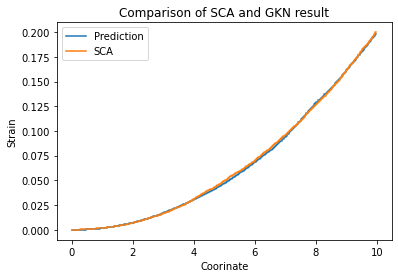

In [125]:
with torch.no_grad():
      for batch in train_vali:
          batch = batch.to(device)
          out = model(batch).detach().cpu()
          pred = batch.y.view(batch_size, -1).cpu()
out = out.numpy()
pred = pred.numpy()
pred = pred.flatten()
coor = batch.X.view(batch_size, -1).cpu().numpy().reshape(-1,1)
plt.step(coor, out*0.2, label = 'Prediction') #assume amplitude 0.2
plt.step(coor, pred*0.2, label = 'SCA')
plt.xlabel('Coorinate')
plt.ylabel('Strain')
plt.title('Comparison of SCA and GKN result')
plt.legend()

tensor([[0.6250, 1.8750, 3.1250, 4.3750, 5.6250, 6.8750, 8.1250, 9.3750]])